In [1]:
import numpy as np
import skimage.io as io
import cv2
import matplotlib.pyplot as plt
import math
import sys
from collections import namedtuple
from PIL import Image

In [2]:
Point = namedtuple('Point', ['x', 'y'])

EPSILON = math.sqrt(sys.float_info.epsilon)


def earclip(polygon):
    ear_vertex = []
    triangles = []

    polygon = [Point(*point) for point in polygon]

    if _is_clockwise(polygon):
        polygon.reverse()

    point_count = len(polygon)
    for i in range(point_count):
        prev_index = i - 1
        prev_point = polygon[prev_index]
        point = polygon[i]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        if _is_ear(prev_point, point, next_point, polygon):
            ear_vertex.append(point)

    while ear_vertex and point_count >= 3:
        ear = ear_vertex.pop(0)
        i = polygon.index(ear)
        prev_index = i - 1
        prev_point = polygon[prev_index]
        next_index = (i + 1) % point_count
        next_point = polygon[next_index]

        polygon.remove(ear)
        point_count -= 1
        triangles.append(((prev_point.x, prev_point.y), (ear.x, ear.y), (next_point.x, next_point.y)))
        if point_count > 3:
            prev_prev_point = polygon[prev_index - 1]
            next_next_index = (i + 1) % point_count
            next_next_point = polygon[next_next_index]

            groups = [
                (prev_prev_point, prev_point, next_point, polygon),
                (prev_point, next_point, next_next_point, polygon),
            ]
            for group in groups:
                p = group[1]
                if _is_ear(*group):
                    if p not in ear_vertex:
                        ear_vertex.append(p)
                elif p in ear_vertex:
                    ear_vertex.remove(p)
    return triangles


def _is_clockwise(polygon):
    s = 0
    polygon_count = len(polygon)
    for i in range(polygon_count):
        point = polygon[i]
        point2 = polygon[(i + 1) % polygon_count]
        s += (point2.x - point.x) * (point2.y + point.y)
    return s > 0


def _is_convex(prev, point, next):
    return _triangle_sum(prev.x, prev.y, point.x, point.y, next.x, next.y) < 0


def _is_ear(p1, p2, p3, polygon):
    ear = _contains_no_points(p1, p2, p3, polygon) and \
        _is_convex(p1, p2, p3) and \
        _triangle_area(p1.x, p1.y, p2.x, p2.y, p3.x, p3.y) > 0
    return ear


def _contains_no_points(p1, p2, p3, polygon):
    for pn in polygon:
        if pn in (p1, p2, p3):
            continue
        elif _is_point_inside(pn, p1, p2, p3):
            return False
    return True


def _is_point_inside(p, a, b, c):
    area = _triangle_area(a.x, a.y, b.x, b.y, c.x, c.y)
    area1 = _triangle_area(p.x, p.y, b.x, b.y, c.x, c.y)
    area2 = _triangle_area(p.x, p.y, a.x, a.y, c.x, c.y)
    area3 = _triangle_area(p.x, p.y, a.x, a.y, b.x, b.y)
    areadiff = abs(area - sum([area1, area2, area3])) < EPSILON
    return areadiff


def _triangle_area(x1, y1, x2, y2, x3, y3):
    return abs((x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)) / 2.0)


def _triangle_sum(x1, y1, x2, y2, x3, y3):
    return x1 * (y3 - y2) + x2 * (y1 - y3) + x3 * (y2 - y1)



In [3]:
def get_hex(s, coef, ct=0):
    approx = cv2.approxPolyDP(s, coef, True)
    edge = len(approx)
    if ct == 500:
        return approx
    if edge > 6:
        return get_hex(s, coef * 2, ct+1)
    elif edge < 3:
        return get_hex(s, coef / 2, ct+1)
    else:
        return approx

def find_same_element(x, y):
    num = 0
    item = []
    for i in x:
        for j in y:
            if list(i) == list(j):
                item.append(i)
                num += 1
    return num, item

def get_adjacent_points(obj, poly):
    adj_point = []
    adj_num = 0
    for triangle in poly:
        num, item = find_same_element(triangle, obj)
        if num == 2:
            adj_num += 1
            adj_point.append(list(item))
    return np.array(adj_point)

def middle_pts(pts):
    assert(len(pts)==2)
    x = 0.5*(pts[0]+pts[1])
    x = x.astype(int)
    return x


def other_pts(pts, triangle):
    assert(len(pts)==2)
    for p1 in triangle:
        flag = 0
        for p2 in pts:
            if list(p1) == list(p2):
                flag = 1
        if flag == 0:
            return p1


In [47]:
def create_scribble(mask): #(coco, anns, height, width):
    im_list = []
    bg = np.zeros((mask.shape))
    x = cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_RGB2BGR)
    x = cv2.dilate(x,np.ones((5,5)), iterations = 4)
    x = cv2.erode(x,np.ones((5,5)), iterations = 4)
    gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    ret, bin = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    ct, h = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for s in ct:
        bg = np.zeros((mask.shape))
        # ratio 0.07 might need to be tuned
        poly = cv2.approxPolyDP(s, 0.07*cv2.arcLength(s, True), True)
        poly = poly.reshape((poly.shape[0], poly.shape[2]))
        if len(poly) == 1:
            x, y = poly[0]
            bg[x-5:x+5,y-5:y+5] == 1
            im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
            continue
        elif len(poly) == 2:
            cv2.polylines(bg, [poly], 0, 1)
            im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
            continue
        # print(poly.shape)
        # print(poly)
        poly_tri = np.array(earclip(poly))
        # assert(poly_tri.shape[0] == len(poly) - 2)
        if len(poly_tri.shape) != 3:
            continue
        assert(poly_tri.shape[1] == 3)
        assert(poly_tri.shape[2] == 2)
        if len(poly_tri) == 1:
            bg = np.zeros((mask.shape))
            adj_point = poly_tri[0]
            #print('adj', adj_point)
            middle_12 = middle_pts(adj_point[:2])
            # print(middle_12)
            # print(adj_point[2])
            len_12 = np.linalg.norm(middle_12 - adj_point[2])
            middle_23 = middle_pts(adj_point[1:])
            len_23 = np.linalg.norm(middle_23 - adj_point[0])
            middle_13 = middle_pts([adj_point[0], adj_point[2]])
            len_13 = np.linalg.norm(middle_13 - adj_point[1])
            lenall = [len_12, len_13, len_23]
            if len_12 == np.max(lenall):
                apex = np.vstack((middle_12, adj_point[2])).astype(int)
            elif len_23 == np.max(lenall):
                apex = np.vstack((middle_23, adj_point[0])).astype(int)
            else:
                apex = np.vstack((middle_13, adj_point[1])).astype(int)
            cv2.polylines(bg, [apex], 0, 1)
            im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
        else:
            for i in poly_tri:
                bg = np.zeros((mask.shape))
                adj_point = get_adjacent_points(i,poly_tri)
                if len(adj_point)>0:
                    if len(adj_point) == 1:
                        adj_point = adj_point[0]
                        apex = np.vstack((middle_pts(adj_point), other_pts(adj_point, i))).astype(int)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    elif len(adj_point) == 2:
                        apex = np.vstack((middle_pts(adj_point[0]), middle_pts(adj_point[1]))).astype(int)
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                    else:
                        assert(len(adj_point) == 3)
                        m1 = middle_pts(adj_point[0])
                        m2 = middle_pts(adj_point[1])
                        m3 = middle_pts(adj_point[2])
                        m12 = middle_pts([m1,m2])
                        apex = np.vstack((m1,m2))
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
                        apex = np.vstack((m12,m3))
                        cv2.polylines(bg, [apex], 0, 1)
                        im_list.append(cv2.dilate(bg,np.ones((3,3)), iterations = 4))
    if len(im_list)>0:
        t = im_list[0].astype(np.int64).flatten()
        for i in range(1,len(im_list)):
            t = np.bitwise_or(t, im_list[i].astype(np.int64).flatten())
        t = t.reshape((mask.shape))
    else:
        t = mask
    return t

In [57]:
imgnpy = np.load('water_v2/river_train.npy',allow_pickle=True) # image name list
saveFolder = 'scribble_river' # NEED CHANGE, to folder that save scribble masks

for imgName in imgnpy:
    if imgName[0] == 'A':
        dataFolder = r'water_v2/Annotations/ADE20k'
    else:
        dataFolder = r'water_v2/Annotations/river_segs'
        imgName = imgName[:-3] + 'png'
    mask = Image.open('{}/{}'.format(dataFolder, imgName))
    mask = np.array(mask)
    scribble = create_scribble(mask)
    imgScr = Image.fromarray((scribble*255).astype(np.uint8))
    imgScr.save('{}/{}'.format(saveFolder, imgName))
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


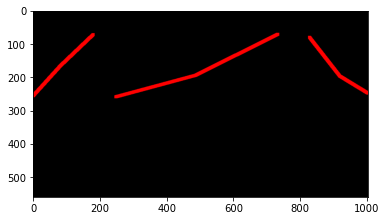

In [51]:
# test
# its a 0-1 image, so need to change to float type to see it
x=Image.open('scribble_river/{}'.format(imgName))
i=np.array(x).astype(float)
plt.imshow(i)

1
1
1
2
1
3
9
2


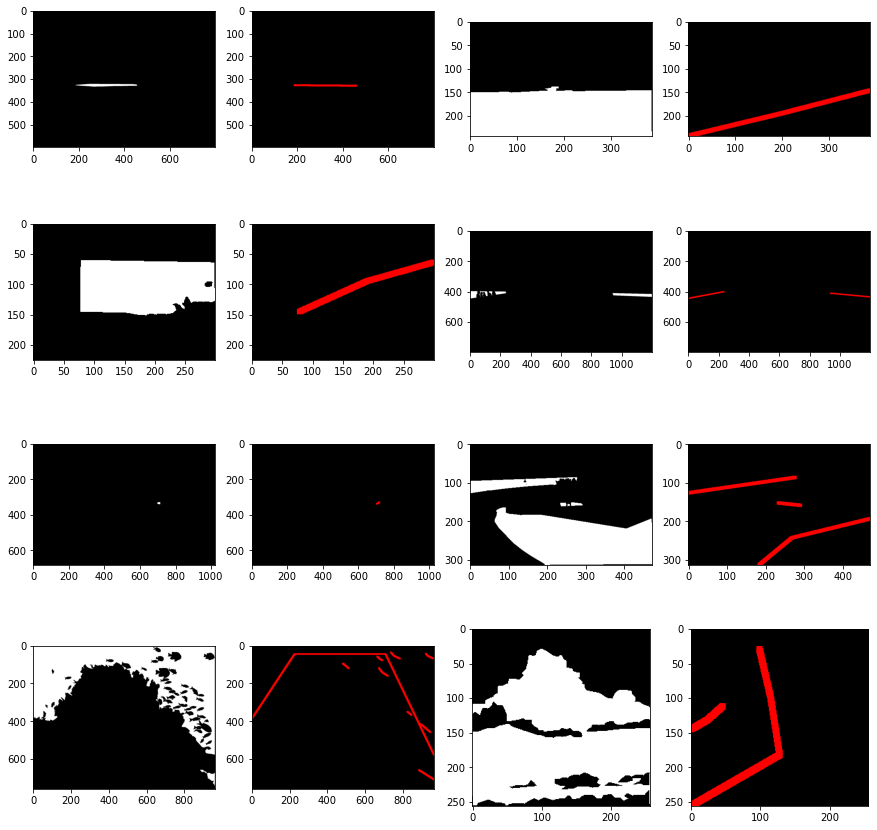

In [49]:
# sample
imgnpy = np.load('water_v2/river_train.npy',allow_pickle=True)
dataFolder = r'water_v2/Annotations/ADE20k'
i = 0
plt.figure(figsize=(15,15))
for i,j in enumerate(range(8,16)):
    imgName = imgnpy[j]
    img = Image.open('{}/{}'.format(dataFolder, imgName))
    plt.subplot(4,4,2*i+1)
    plt.imshow(img)
    scr = create_scribble(np.array(img)).astype(float)
    plt.subplot(4,4,2*i+2)
    plt.imshow(scr)